In [12]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import boston_housing
from keras import (models, layers)

In [13]:
# Extract training and test samples

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [14]:
# Normalize data

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# Normalize test with train mean/std
test_data -= mean
test_data /= std

In [15]:
# Define model

def build_model():
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation="relu",
                          input_shape=(train_data.shape[1],)
                          ))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))
    
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    
    return model

In [18]:
# K-fold validation

k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print("Processing fold {}".format(i))
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs=num_epochs, batch_size=1, verbose=0
                       )
    mae_history = history.history["mae"]
    all_mae_histories.append(mae_history)

Processing fold 0
Processing fold 1
Processing fold 2
Processing fold 3


In [19]:
# Build average history for epochs
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

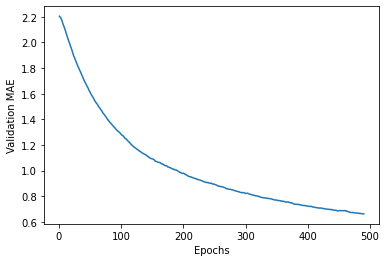

In [20]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

# Plot
plt.plot(range(1, len(smooth_mae_history) + 1) , smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [21]:
# Train final model
model = build_model()
model.fit(train_data, train_targets,
         epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 17.5291 - mae: 2.5851
